# Introductory applied machine learning (INFR10069) 

# Lab 5: Clustering, PCA, and Evaluation

In this lab we consider unsupervised learning in the form of clustering methods and principal component analysis (PCA), as well as more thorough performance evaluation of classifiers.

All the datasets that you will need for this lab are located at the `./datasets` directory which is adjacent to this file.

In [1]:
# Import packages
from __future__ import division, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
%matplotlib inline

## Part 1: Clustering the landsat dataset

We first consider clustering of the Landsat data. For information about the Landsat data you can read [this description](http://www.inf.ed.ac.uk/teaching/courses/dme/html/landsat.html). Since there are 6 classes in the data, it would be interesting to try clustering with k=6 centres...

### ========== Question 1.1 ==========
1. With pandas, read the csv dataset located at './datasets/landsat.csv'
1. Split the data into the features `X` (pandas dataframe), and the labels `y` (easier to make it a numpy array)
1. Give it a once over
    * Get a feel for the size
    * Check it looks ok
    * Understand what the features are
    * Plot the class distribution

In [2]:
# Your code goes here

data_path = os.path.join(os.getcwd(), 'datasets', 'landsat.csv')
landsat = pd.read_csv(data_path, delimiter = ',')

In [3]:
# Your code goes here

X = landsat.drop('class', axis=1)
y = landsat['class'].values

Number of instances: 4435, number of attributes: 36
          pixel1_1     pixel1_2     pixel1_3     pixel1_4     pixel2_1  \
count  4435.000000  4435.000000  4435.000000  4435.000000  4435.000000   
mean     69.473957    83.855242    99.322886    82.555581    69.208794   
std      13.649635    22.725079    16.672166    18.695450    13.552423   
min      40.000000    27.000000    56.000000    33.000000    40.000000   
25%      60.000000    71.000000    85.000000    70.000000    60.000000   
50%      68.000000    87.000000   101.000000    83.000000    68.000000   
75%      80.000000   103.000000   113.000000    92.000000    80.000000   
max     104.000000   137.000000   140.000000   154.000000   102.000000   

          pixel2_2     pixel2_3     pixel2_4     pixel3_1     pixel3_2  \
count  4435.000000  4435.000000  4435.000000  4435.000000  4435.000000   
mean     83.499436    99.174521    82.480496    68.963472    83.131003   
std      22.811809    16.627583    18.714272    13.497858  

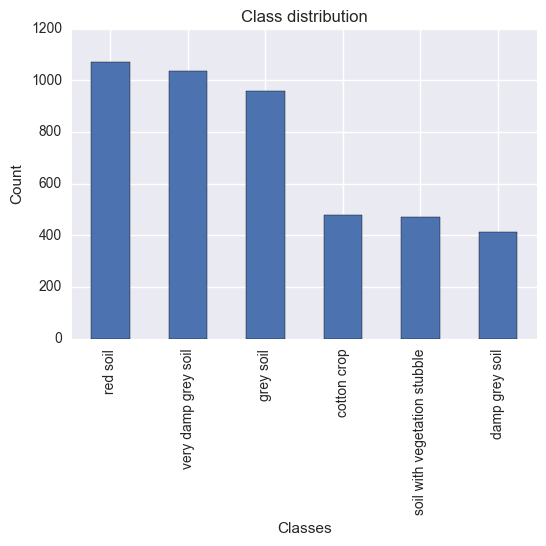

In [4]:
# Your code goes here

print('Number of instances: {}, number of attributes: {}'.format(X.shape[0], X.shape[1]))
print(landsat.describe())
# Notice that class is categorical (not numeric) and count
labeldict = {1:'red soil', 2:'cotton crop', 3:'grey soil',
             4:'damp grey soil', 5:'soil with vegetation stubble',
             6:'mixture class (all types present)',
             7:'very damp grey soil'}
fig, ax = plt.subplots()
landsat['class'].astype('category').value_counts().plot(kind='bar', ax=ax)
labels = [int(ticklabel.get_text()) for ticklabel in ax.get_xticklabels()]
ax.set_xticklabels([labeldict[l] for l in labels])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class distribution')
plt.show()

In [5]:
# Advanced (not expecting you to have done this) - describe pixel values by band

landsat_melt = pd.melt(landsat, id_vars=['class'], var_name='pixel_label')
landsat_melt['band'] = landsat_melt['pixel_label'].str[-1]
landsat_melt.groupby('band')['value'].describe()

band       
1     count    39915.000000
      mean        69.128022
      std         13.556420
      min         39.000000
      25%         60.000000
      50%         68.000000
      75%         80.000000
      max        104.000000
2     count    39915.000000
      mean        83.450482
      std         22.790675
      min         27.000000
      25%         71.000000
      50%         85.000000
      75%        103.000000
      max        137.000000
3     count    39915.000000
      mean        99.188876
      std         16.689490
      min         50.000000
      25%         85.000000
      50%        101.000000
      75%        113.000000
      max        145.000000
4     count    39915.000000
      mean        82.566429
      std         18.836535
      min         29.000000
      25%         69.000000
      50%         81.000000
      75%         92.000000
      max        157.000000
Name: value, dtype: float64

### ========== Question 1.2 ==========

*Tip - don't get stuck on this, move on after 10 mins or so (it's not critical)*

Plot a few datapoints. You'll need to understand and reshape the datapoints to do this. *Hint: try reading the [detailed description](http://www.inf.ed.ac.uk/teaching/courses/dme/html/satdoc.txt), it'll take you 2 minutes...`plt.imshow()` or `sns.heatmap()` (with an `ax.invert_yaxis()`) may also be handy ;)*

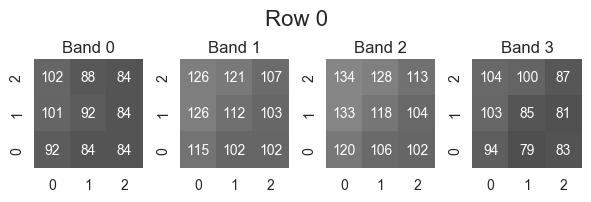

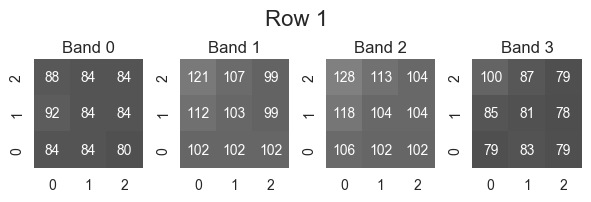

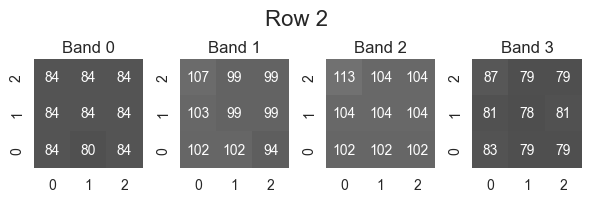

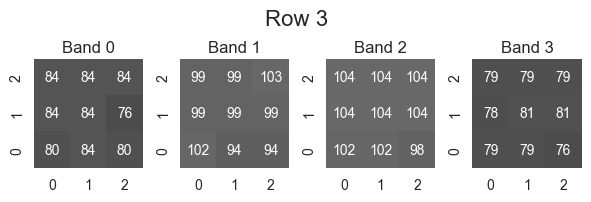

In [6]:
# Your code goes here

def get_images(row, bands=None):    
    # Get each of the 4 3x3 images contained in the row
    # Pixels are labeled 1 to 9 from topleft to bottom right
    # They are measured at 4 spectral bands
    #
    # row - a numpy array
    if bands is None:
        img = [[]] * 4
        for ii in range(4):
            img[ii] = row[[4*p + ii for p in range(9)]].reshape((3,3)).astype(int)
    elif isinstance(bands, int):
        img = row[[4*p + bands for p in range(9)]].reshape((3,3)).astype(int)
    elif isinstance(bands, list):
        img = [[]] * len(bands)
        for ii, band in enumerate(bands):
            img[ii] = row[[4*p + band for p in range(9)]].reshape((3,3)).astype(int)
    return img
        
for ii in range(4):
    fig, ax = plt.subplots(1,4)
    plt.suptitle('Row {}'.format(ii), fontsize=16)
    for jj, img in enumerate(get_images(landsat.iloc[ii,:])):
        ax[jj] = sns.heatmap(img, annot=True, fmt="d", ax=ax[jj], vmin=0, vmax=255, 
                    cbar=False, square=True, cmap=plt.cm.gray)
        ax[jj].invert_yaxis()
        ax[jj].set_title('Band {}'.format(jj))
    plt.tight_layout()
    plt.subplots_adjust(top=1.4)

### ========== Question 1.3 ==========

Read [this demonstration of k-means clustering assumptions](http://scikit-learn.org/0.17/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py) from the sklearn documentation. Get a feel for how to create and fit a k-means object and what the different arguments do.

Initialise a [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 6 clusters, and one other parameter that ensures you can reproduce your results (other arguments kept as default). Call the object `kmeans`. Use the `fit()` method to fit to the training data (`X` - the features of `landsat` created above)

**Be careful to fit `X` - only the features - not the class labels!**

In [7]:
# Your code goes here

# It's really important that you set a random_state such that you can
# reproduce your results
kmeans = KMeans(n_clusters=6, random_state=1337)  
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1337, tol=0.0001,
    verbose=0)

### ========== Question 1.4 ==========

So, how well did that work? Are the classes well separated and form 6 nice clusters? The sklearn documentation gives a great introduction to k-means [here](http://scikit-learn.org/stable/modules/clustering.html#k-means). It describes what the algorithm is trying to minimise - the squared difference between datapoints and their closest cluster centre - a.k.a. the **inertia**. Lower inertia implies a better fit.

Since we have the true class labels in this case, we can use another metric: the [adjusted rand index](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation). Understand what it is and roughly how it is calculated (try the [mathematical formulation on sklearn](http://scikit-learn.org/stable/modules/clustering.html#mathematical-formulation) or [on wikipedia](https://en.wikipedia.org/wiki/Rand_index)).

Print the `inertia` and the `adjusted_rand_score` of the kmeans object. The inertia is contained within the `kmeans` object you just fitted as a property. You need to use `y` and the cluster labels (another property of the `kmeans` object you just made), and are welcome to use the sklearn metrics function [adjusted_rand_score](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.adjusted_rand_score.html).

In [8]:
# Your code goes here

kmeans.inertia_, adjusted_rand_score(y, kmeans.labels_)

(11321534.196063019, 0.5345236259496987)

### ========== Question 1.5 ==========

Let's have a look at the counts of the labels within each cluster. If the clustering has worked well, and the labels are inticative of genuine difference in the data, we should expect each cluster to have one dominant label.

Use `sns.countplot` on `kmeans.labels_` with a hue of `y` to get a plot that counts the number of instances within each cluster, and breaks them down by the class labels.

Below the plot, comment on:
1. How successful the clustering has been at separating data with different labels
1. Focussing on clusters, which are the best?
1. Focussing on labels, which are well identified by the clustering?
1. Which labels are the hardest to determine by the data point cluster assignment?

**Extension**: create a vector `y_labels` from `y` which has the names for the classes for a more interpretable plot with respect to the data

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans.labels_, hue=y, ax=ax)
plt.xlabel('cluster id')
plt.show()

# --- Extension ---
cats = ['red soil','cotton crop','grey soil', 'damp grey soil', 
        'soil with vegetation stubble', 'mixture class (all types present)',
        'very damp grey soil']
labeldict = dict(zip(range(1,8), cats))
y_labels = pd.Categorical([labeldict[y_i] for y_i in y],
                          categories=[c for c in cats if c != 'mixture class (all types present)']) # ensures colours same
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans.labels_, hue=y_labels, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=[1.1, 0.5], title='Class')
plt.xlabel('cluster id')
plt.show()

*Your answer goes here*
1. How successful the clustering has been at separating data with different labels
    * Hmmm...so so! There are 3 clusters that contain one main type of datapoint: label 3 (grey soil), label 2 (cotton crop), and label 1 (red soil). The other 3 clusters contain a mix.
1. Focussing on clusters, which are the best?
    * If a datapoint in the training set is in the majority label 2 cluster (cotton crop), you can be certain it has label 2, the majority label 1 (red soil), and majority label 3 (grey soil) clusters are similar but not quite as pure
1. Focussing on labels, which are well identified by the clustering?
    * Label 3 (grey soil) data seems well separated in general - most of the datapoints with this label are in one cluster. It's important to note that, though the majority label 2 (cotton crop) cluster contains only label 2 datapoints, there are label 2 data in other clusters. From this we can say that it appears label 2 is mixed up with label 1 (red soil) and label 5 (soil with vegetation stubble).
1. Which labels are the hardest to determine by the data point cluster assignment?
    * label 4 (damp grey soil) is confused with about 1/3 of the label 7 (very damp grey soil) data...this doesn't seem particularly surpising. This label 7 data (very damp grey soil) is often confused with label 5 data (soil with vegetation stubble).

## Part 2: Dimensionality reduction

The landsat data is 36 dimensional, so we cannot visualise it, with respect to class, on a nice two dimensional plot. Additionally, as dimensionality increases, euclidean distance [becomes less meaningful](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Distance_functions)...

Perhaps if we found a lower dimensional subspace the data lies upon, we could more easily distinguish the datapoints...

### ========== Question 2.1 ==========

Have a look at the [PCA example](http://scikit-learn.org/0.17/auto_examples/decomposition/plot_pca_iris.html) in the sklearn documentation. For more information about PCA and decomposition in general check out the sklearn [user guide on decomposition](http://scikit-learn.org/stable/modules/decomposition.html#pca).

We are going to project the data down to 2 dimensions and visualise it using PCA. 

1. Create `pca`, an instance of an [sklearn PCA object](http://scikit-learn.org/0.17/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA), setting n_components to 2. 
1. Create `X_2d` by using the pca method `fit_transform()` and supplying the features `X` to fit and transform to 2d.

In [ ]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

### ========== Question 2.2 ==========

Let's visualise the data! Use a scatterplot and colour the datapoints by their class. You'll find [this example](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html) very helpful to stea-I mean, adapt. 

Below the plot, comment on whether the data looks more or less seperable now. Do the data look like they will be confused by a k-means clustering in the same way now?

**Extension**: Unless the data is somehow magically perfectly seperable, you may want to try and describe the space a little better than a scatterplot (bacause points are plotted on top of one another). Try and make a plot that clarifies the location of the classes. We're actually interested in where the **density** is.

In [ ]:
# Your code goes here

plt.figure(figsize=(12,8))
colours = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']
lw = 2

sub_cats = [c for c in cats if c != 'mixture class (all types present)']
for color, target_name in zip(colours, sub_cats):
    plt.scatter(X_2d[y_labels == target_name, 0], X_2d[y_labels == target_name, 1], color=color, alpha=.5, lw=lw,
                label=target_name)
plt.axis('equal')
plt.legend(loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5])
plt.title('Labelled data in PCA space')
plt.xlabel('PC1')
plt.ylabel('PC2')
top_plot = plt.gca()
plt.show()


# --- extension ---
import matplotlib.lines as mlines
fig, ax = plt.subplots(figsize=(12,8))
colours = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']
lines = []
for ii, cat in enumerate(sub_cats):
    idx = y_labels==cat
    g = sns.kdeplot(X_2d[idx, :], ax=ax, n_levels=20, 
                    cmap=sns.dark_palette(colours[ii], as_cmap=True))
ax.set_xlim(top_plot.get_xlim())
ax.set_ylim(top_plot.get_ylim())
patches = [mlines.Line2D([], [], color=colours[ii], label=cat) for ii, cat in enumerate(sub_cats)]
plt.legend(patches, sub_cats, loc='center left', scatterpoints=3, bbox_to_anchor=[1.01, 0.5])
plt.title('Kernel density plots for each class')
plt.show()

*Your answer goes here*

Without performing a clustering, it's hard to say whether the data is more or less seperable. However, we can see 6 definite clusters with some overlap in the top plot, but it's not all that clear. The kernel density plot allows us to see better where the density lies. These clusters are not spherical and there is overlap, so k-means will always fail. See in particular the 'red soil' data points vs. the 'soil with vegetation stubble points. As expected, we see the 'cotton crop' data points are very distinct from the rest. 

### ========== Question 2.3 ==========

Let's find out whether it's easier to model the transformed data. Fit k-means to the transformed data and report the inertia and the adjusted rand index. Below, comment on whether it is better or worse.

In [ ]:
# Your code goes here

kmeans_pca = KMeans(n_clusters=6, random_state=1337)  
kmeans_pca.fit(X_2d)
kmeans_pca.inertia_, adjusted_rand_score(y, kmeans_pca.labels_)

*Your answer goes here*

The fit is not as good as before, the adjusted rand index is lower. Note that we cannot compare the inertia with before. You should think about why.

### ========== Question 2.4 ==========

The blobs in the 2 dimensional plot do look quite gaussian...try another classifier on the 2d data and see if it can perform better. What about using 3 principal component? 

Maybe there are subclasses within each class? Maybe increasing the number of clusters will increase your `adjusted_rand_score`.

Use the adjusted rand score for fair comparison. Why do you think it works better or worse? Discuss with your colleagues and lab tutors why you think you got better/worse/the same results.

In [ ]:
# Your code goes here


# Here are just some examples you could try
# Anything goes for this question


# In my solution I find that there seems to be a sweet spot around 10 clusters
# This provides some evidence that the classes are multimodal. You can see that
# in the plots.
#
# increasing to 3 principal component dimensions
# provides a big benefit for kmeans and a Gaussian Naive Bayes classifier.
# In fact, it's better than using the full data. 
# Using a random forest, I get the best results using the full data - N.B.
# I'm using the Out-of-bag error here (the training error is 0% as discussed before)
# so we may find that this is overfitting if given a test set.



from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


for ii in range(1,20,2):
    km = KMeans(n_clusters=ii, random_state=1337)  
    km.fit(X_2d)
    y_pred = km.labels_
    print('\nk-means with {} clusters results\nARI: {}, Inertia: {}'.\
          format(ii, adjusted_rand_score(y, y_pred), km.inertia_))


for ii in range(2, 6):
    X_pca = PCA(n_components = ii).fit_transform(X)
    km = KMeans(n_clusters=6, random_state=1337)  
    km.fit(X_pca)
    y_pred = km.labels_
    print('\n{}D PCA data, kmeans results\nARI: {}, Inertia: {}'.\
          format(ii, adjusted_rand_score(y, y_pred), km.inertia_))

for ii in range(2, 6):
    X_pca = PCA(n_components = ii).fit_transform(X)
    gnb = GaussianNB()
    gnb.fit(X_pca, y)
    y_pred = gnb.predict(X_pca)
    print('\n{}D PCA data, GNB results\nARI: {}, Mean Accuracy: {}'.\
          format(ii, adjusted_rand_score(y, y_pred), gnb.score(X_pca, y)))

gnb = GaussianNB()
gnb.fit(X, y)
y_pred = gnb.predict(X)
print('\nFull data, GNB results\nARI: {}, Mean Accuracy: {}'.format(adjusted_rand_score(y, y_pred), gnb.score(X, y)))

for ii in range(2, 6):
    X_pca = PCA(n_components = ii).fit_transform(X)
    rf = RandomForestClassifier(n_estimators=100, random_state=1337, oob_score=True)
    rf.fit(X_pca, y)
    y_pred = np.argmax(rf.oob_decision_function_, axis=1)
    print('\n{}D PCA data, RF results\nARI: {}, Mean Accuracy: {}'.\
          format(ii, adjusted_rand_score(y, y_pred), rf.oob_score_))

rf = RandomForestClassifier(n_estimators=100, random_state=1337, oob_score=True)
rf.fit(X, y)
y_pred = np.argmax(rf.oob_decision_function_, axis=1)
print('\nFull data, RF results\nARI: {}, Mean Accuracy: {}'.\
      format(adjusted_rand_score(y, y_pred), rf.oob_score_))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=300)

pca = PCA(n_components=3)
pca.fit(X)
X_3d = pca.transform(X)
for ii, cat in enumerate(sub_cats):
    idx = y_labels==cat
    ax.scatter(X_3d[idx, 0], X_3d[idx, 1], X_3d[idx, 2], c=colours[ii],
               label = cat)
plt.legend(loc='center left', bbox_to_anchor=[1.1, .5])
plt.show()

# Credits

Lab prepared by Lawrence Murray and Chris Williams, November 2008; revised Athina Spiliopoulou Nov 2009; revised Sean Moran Nov 2011; revised Boris Mitrovic Oct 2013; revised and converted to ipython notebook by James Owers and Agamemnon Krasoulis Oct 2016